In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time
import numpy as np
import os

In [2]:
import pandas as pd

dataset_path ='data/nhanes_III_result.csv'
column_names = [
        "ID",
        "SEX",
        "AGE",
        "STANDING_HEIGHT_BABY",
        "STANDING_HEIGHT",
        "SITTING_HEIGHT",
        "SELF_HEIGHT",
        "UPPER_LEG"]


raw_dataset = pd.read_csv(dataset_path, names=column_names)

dataset = raw_dataset.copy()
dataset.tail()

,ID,SEX,AGE,STANDING_HEIGHT_BABY,STANDING_HEIGHT,SITTING_HEIGHT,SELF_HEIGHT,UPPER_LEG
31308,53596,Male,01,,,,,
31309,53616,Male,85,172.8,172.72,90.0,,0038
31310,53617,Male,07,128.4,128.524,64.8,,0032
31311,53621,Male,01,,,,,
31312,53623,Female,17,165.2,165.1,88.5,,37.5


## Pre-Processing 

In [3]:
x = dataset['SITTING_HEIGHT']
x_age = dataset['AGE']
y = dataset['STANDING_HEIGHT']

# 29089

x_train = []
y_train = []


for index, value in enumerate(x):
    if index >=2 and int(x_age[index]) < 18:
        if (value != '     ') and (float(value) > 10.0):
            if float(y[index]) < 300:
                x_train.append(float(value))
                y_train.append(float(y[index]))
    
x_train_float = np.array(x_train[1:len(x_train)-150])
y_train_float = np.array(y_train[1:len(y_train)-150])

x_test_float =  np.array(x_train[-150:])
y_test_float =  np.array(y_train[-150:])

print(len(x_train_float))
print(len(y_test_float))


9962
150


In [4]:
x_max = np.amax(x_train_float)
y_max = np.amax(y_train_float)
x_train_float = x_train_float / x_max
y_train_float = y_train_float / y_max

print(x_max, y_max)

110.2 194.056


Text(0.5, 0, 'x')

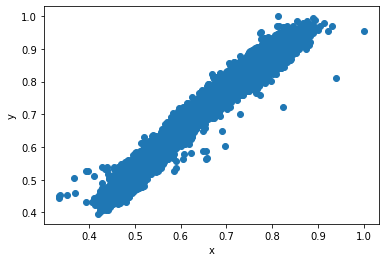

In [5]:

plt.plot(x_train_float , y_train_float , 'o')
plt.ylabel("y")
plt.xlabel("x")

## Network

epoch: 2, loss = 0.00103
epoch: 4, loss = 0.00066
epoch: 6, loss = 0.00067
epoch: 8, loss = 0.00067
epoch: 10, loss = 0.00067
epoch: 12, loss = 0.00067
epoch: 14, loss = 0.00066


Text(0, 0.5, 'Loss')

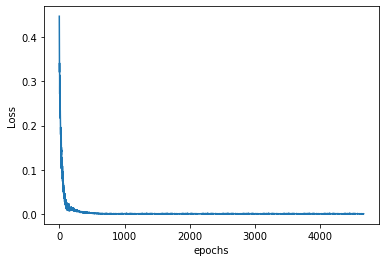

In [6]:
# 0) Prepare data

X = torch.from_numpy(np.array(x_train_float, dtype='float32'))
Y = torch.from_numpy(np.array(y_train_float, dtype='float32'))
y = Y.view((Y.shape[0], 1))
x  = X.view((X.shape[0], 1))

# 1) Model

input_size = 1
output_size = 1
#model = nn.Linear(input_size, output_size)

class MyModelB(nn.Module):
    def __init__(self):
        super(MyModelB, self).__init__()
        self.fc1 = nn.Linear(1, 4)
        self.fc2 = nn.Linear(4 ,1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x
    
model = MyModelB()

# 2) Loss and optimizer
learning_rate = 0.001

criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)  


# Batch Size 
Batch_size = 32
Datset_size= len(X)

iteration = Datset_size // Batch_size

# 3) Training loop
num_epochs = 15
losses = []
for epoch in range(num_epochs):
    # Forward pass and loss

    for i in range(iteration):
        x_batch = x[i*Batch_size:i*Batch_size+ Batch_size]
        y_batch = y[i*Batch_size:i*Batch_size+ Batch_size]
        y_predicted = model(x_batch)
        loss = criterion(y_predicted, y_batch)
        losses.append(loss)

        # Backward pass and update
        loss.backward()
        optimizer.step()
        # zero grad before new step
        optimizer.zero_grad()
        #print('iteration_{}_loss_ {}'.format(i, loss))

    if (epoch+1) % 2 == 0:
            print(f'epoch: {epoch+1}, loss = {loss.item():.5f}')

plt.plot(range(num_epochs*iteration), losses)
plt.xlabel("epochs")
plt.ylabel("Loss")

## Evaluation


In [7]:
x_test = torch.from_numpy(np.array(x_test_float/x_max, dtype='float32'))
x_test = x_test.view(x_test.shape[0],1)

output = model.forward(x_test)
output *= y_max

total_loss = 0
for index, sample in enumerate(output):
    loss = abs(sample - y_test_float[index]) 
    #print(loss, sample, y_test_float[index])
    
    total_loss += loss
mean_absolute_error = total_loss / len(output)
print(mean_absolute_error)


tensor([3.6707], grad_fn=<DivBackward0>)


## Saving Model

In [8]:
dirName = 'Trained_models/sitting_height_under18'
PATH = 'Trained_models/sitting_height_under18/sitting_height_under18_{}'.format(mean_absolute_error.item())

if not os.path.exists(dirName):
    os.mkdir(dirName)
    print("Directory ", dirName , "Created")
else:    
    print("Directory ", dirName , "already exists")
        
torch.save(model.state_dict(), PATH)
#the_model = torch.load(PATH)

Directory  Trained_models/sitting_height_under18 Created


## Average Loss with Pre-calculated weight

In [9]:
C1 = 0.278
C2 = 41.507
total_loss = 0

for index, femur in enumerate(x_test_float):
    
    height = (C1 * femur *10) + C2 
    total_loss += abs(height- y_test_float[index])
    #print(abs(height- y1[index]/10))
    #print(knee_height, height, y1[index]/10)
    
print(total_loss/len(x_test_float))
       

101.012813333


In [ ]:
state_dict = model.state_dict()
for name, param in state_dict.items():
    print(param.data)
    


In [10]:
x_test_float[0]

53.600000000000001

In [11]:
y_test_float[0]

92.201999999999998

In [12]:
x_max


110.2

In [13]:
y_max

194.05600000000001